# Predicting Credit Card Default

### Data Set Information:

**This research aimed at the case of customers default payments in Taiwan**

### Features description:

- LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- SEX: Gender (1 = male; 2 = female). 
- EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- MARRIAGE: Marital status (1 = married; 2 = single; 3 = others). 
- AGE: Age (year). 
- PAY_0 - PAY_6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 0 = the repayment status in September, 2005; 1 = the repayment status in August, 2005; . . .; 6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- BILL_AMT1-BILL_AMT6: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- PAY_AMT1-PAY_AMT6: Amount of previous payment (NT dollar).
- default payment next month: **positive class: default | negative class: pay**

In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## 0. Data Preparation

In [7]:

import types
import pandas as pd
# from botocore.client import Config
# import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
# client_e97e68ebf9b8407dbba35db6b219f5b5 = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id='aG7scVoB7LV-UQdUopU1DaTpAimfDfMLicikBOkQmJrC',
#     ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
#     config=Config(signature_version='oauth'),
#     endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

# body = client_e97e68ebf9b8407dbba35db6b219f5b5.get_object(Bucket='samplesparkproject-donotdelete-pr-aony7xlzel44ws',Key='UCI_Credit_Card.csv')['Body']
# # add missing __iter__ method, so pandas accepts body as file-like object
# if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# df_data_1 = pd.read_csv(body, index_col="ID")
#df_data_1.head()

default = pd.read_csv('UCI_Credit_Card.csv', index_col="ID")
# default = df_data_1
default.rename(columns=lambda x: x.lower(), inplace=True)
# Base values: female, other_education, not_married
default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')
default.drop('education', axis=1, inplace=True)

default['male'] = (default['sex']==1).astype('int')
default.drop('sex', axis=1, inplace=True)

default['married'] = (default['marriage'] == 1).astype('int')
default.drop('marriage', axis=1, inplace=True)

# For pay features if the <= 0 then it means it was not delayed
pay_features = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for p in pay_features:
    default.loc[default[p]<=0, p] = 0

default.rename(columns={'default payment next month':'default'}, inplace=True) 

# Building models using all features

In [8]:
default.shape

(30000, 26)

In [42]:
default.columns

Index(['limit_bal', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5',
       'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4',
       'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3',
       'pay_amt4', 'pay_amt5', 'pay_amt6', 'default.payment.next.month',
       'grad_school', 'university', 'high_school', 'male', 'married'],
      dtype='object')

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [11]:
target_name = 'default.payment.next.month'
X = default.drop('default.payment.next.month', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)

In [12]:
def CMatrix(CM, labels=['pay','default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

### Preparing a DataFrame for model analysis

In [13]:
# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], 
                      columns=['NULL','LogisticReg', 'ClassTree', 'NaiveBayes'])

- **Accuracy**: the proportion of the total number of predictions that are correct
- **Precision**: the proportion of positive predictions that are actually correct
- **Recall**: the proportion of positive observed values correctly predicted as such

**In this application:**
- **Accuracy**: Overall how often the model predicts correctly defaulters and non-defaulters
- **Precision**: When the model predicts **default**: how often is correct?
- **Recall**: The proportion of **actual defalters** that the model will correctly predict as such

#### Which metric should I use?

- **False Positive**: A person who will pay predicted as defaulter
- **False Negative**: A person who default predicted as payer

#### False negatives are worse => look for a better recall

## The Null model: always predict the most common category

In [14]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

C:\Users\RLE0700\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


PREDICTION,pay,default,Total
TRUE,,,
pay,4673,0,4673
default,1327,0,1327
Total,6000,0,6000


## A. Logistic Regression

In [15]:
# 1. Import the estimator object (model)
from sklearn.linear_model import LogisticRegression

# 2. Create an instance of the estimator
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)

# 3. Use the trainning data to train the estimator
logistic_regression.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

C:\Users\RLE0700\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\RLE0700\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


PREDICTION,pay,default,Total
TRUE,,,
pay,4480,193,4673
default,894,433,1327
Total,5374,626,6000


## B. Classification Trees

In [16]:
# 1. Import the estimator object (model)
from sklearn.tree import DecisionTreeClassifier

# 2. Create an instance of the estimator
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)

# 3. Use the trainning data to train the estimator
class_tree.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = class_tree.predict(X_test)
metrics.loc['accuracy','ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,4226,447,4673
default,827,500,1327
Total,5053,947,6000


## C. Naive Bayes Classifier

In [17]:
# 1. Import the estimator object (model)
from sklearn.naive_bayes import GaussianNB

# 2. Create an instance of the estimator
NBC = GaussianNB()

# 3. Use the trainning data to train the estimator
NBC.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3877,796,4673
default,585,742,1327
Total,4462,1538,6000


In [68]:
100*metrics

,NULL,LogisticReg,ClassTree,NaiveBayes
accuracy,77.8833,81.8833,78.7667,76.9833
precision,0,69.1693,52.7983,48.2445
recall,0,32.63,37.679,55.9156


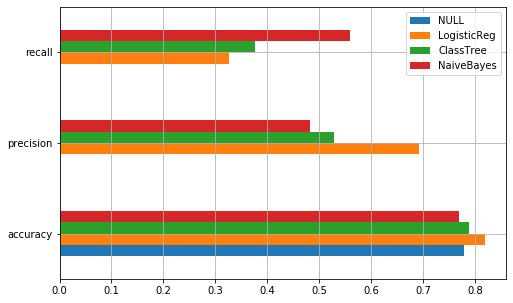

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [70]:
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=NBC.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=logistic_regression.predict_proba(X_test)[:,1])

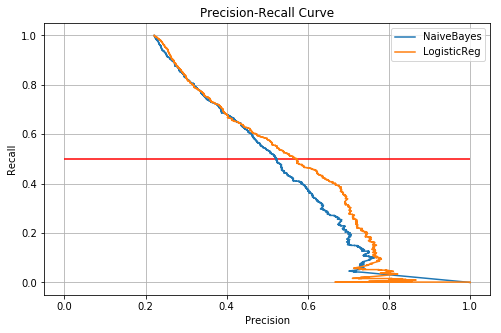

In [71]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_lr, recall_lr, label='LogisticReg')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

### Confusion matrix for modified Logistic Regression Classifier

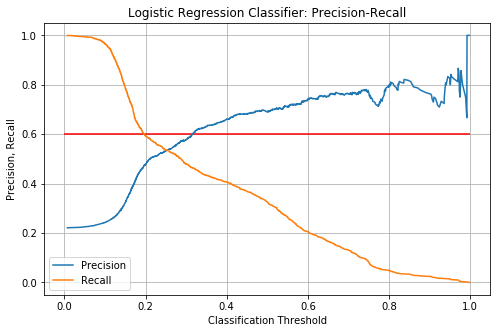

In [72]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Regression Classifier: Precision-Recall')
ax.hlines(y=0.6, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

### Classifier with threshold of 0.2

In [73]:
y_pred_proba = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.2).astype('int')
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall: ", 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print("Precision: ", 100*precision_score(y_pred=y_pred_test, y_true=y_test))
CMatrix(CM)

Recall:  59.2313489073
Precision:  47.7811550152


PREDICTION,pay,default,Total
TRUE,,,
pay,3814,859,4673
default,541,786,1327
Total,4355,1645,6000


### Making individual predictions

In [38]:
def make_ind_prediction(new_data):
    data = new_data    
    data = robust_scaler.transform(data)
    print(data)
    prob = logistic_regression.predict_proba(data)[0][1]
    #print('Prob for class %s: %.2f' % ('default', prob[0]))
    #print('Prob for class %s: %.2f' % ('non-default', prob[1]))
    if prob >= 0.2:
        print(prob)
        return 'Will default'
    else:
        print(prob)
        return 'Will pay'

In [41]:
# from collections import OrderedDict
# new_customer = OrderedDict([('limit_bal', 500),('age', 43 ),
#                             ('bill_amt1', 1683),('bill_amt2', 1828 ),('bill_amt3', 3502 ),('bill_amt4', 8979 ), ('bill_amt5', 5190 ),('bill_amt6', 0 ), 
#                             ('pay_amt1', 0 ),('pay_amt2', 0 ),('pay_amt3', 0 ),('pay_amt4', 0 ),('pay_amt5', 0 ), ('pay_amt6', 0 ),
#                             ('male', 1 ),('grad_school', 0 ),('university', 1 ), ('high_school', 0 ),('married', 0 ),
#                             ('pay_0', 0 ),('pay_2', 0 ),('pay_3', 0), ('pay_4', 0),('pay_5', 0), ('pay_6', 0)])

# new_customer = pd.Series(new_customer)
# print(new_customer.values.reshape(1, -1))
# make_ind_prediction(new_customer.values.reshape(1, -1))
# #new_customer = pd.Series(new_customer)
new_customer = X_test[9].reshape(1, -1)
print(X_test[9].reshape(1, -1))
make_ind_prediction(new_customer)

[[ 0.42105263  0.46153846  0.          0.          0.          0.
   0.          0.         -0.00726403 -0.34741853 -0.34937433 -0.25489059
  -0.19878168 -0.16133995 -0.52421368 -0.48212143  0.96038882  0.40352411
  -0.13231013  0.12879129  0.          1.          0.          0.
   1.        ]]
[[-0.73683989 -2.57988166  0.          0.          0.          0.
   0.          0.         -0.35228576 -0.34742423 -0.34938041 -0.36513087
  -0.37385161 -0.3560776  -0.52434454 -0.48223713 -0.43719067 -0.40341556
  -0.39696542 -0.38634071  0.          1.          0.          0.
   1.        ]]
0.16674189829372363


'Will pay'

In [ ]:
Index(['limit_bal', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5',
       'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4',
       'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3',
       'pay_amt4', 'pay_amt5', 'pay_amt6', 'default.payment.next.month',
       'grad_school', 'university', 'high_school', 'male', 'married'],
      dtype='object')